# Joint Position Limits

Let us try to understand why it is hard to account for joint position limits when controlling a robotic system.
We will use the following notation:
* $q$ represents the joint angles
* $\dot{q}$ represents the joint velocities
* $\ddot{q}$ represents the joint accelerations

## Simulation
We can simulate the robot dynamics as if it were a simple double integrator with time step $\Delta t$:
$$
q[i+1] = q[i] + \Delta t \, \dot{q}[i] + \frac{\Delta t^2}{2} \, \ddot{q}[i]
$$

$$
\dot{q}[i+1] = \dot{q}[i] + \Delta t \, \ddot{q}[i]
$$

## Joint position, velocity and acceleration bounds
Usually a robot has bound joint positions, velocities and accelerations. Accelerations are typically bounded indirectly by the motor torque bounds. However, for simplicity, let us assume here that we have direct acceleration bounds:
$$
q^{min} \le q \le q^{max}, \quad | \dot{q} | \le \dot{q}^{max}, \quad \ddot{q}^{min} \le \ddot{q} \le \ddot{q}^{max}
$$

## Implementation
Let us now simulate the motion of a single joint, assuming we apply maximum acceleration for the whole duration of the simulation.

In [27]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.grid'] = True

In [28]:
N = 100    # number of time step of the simulation
dt = 0.01  # time step of the simulation and the controller
q_max = 1  # maximum joint position
ddq_max = 3 # maximum joint acceleration

In [29]:
# Create numpy arrays to contain the trajectories of joint pos, vel, acc
q = np.zeros(N)
dq = np.zeros(N)
ddq = np.ones(N-1) * ddq_max

In [30]:
# simulate the double integrator dynamics
for i in range(N-1):
    q[i+1] = q[i] + dt*dq[i] + 0.5*dt*dt*ddq[i]
    dq[i+1] = dq[i] + dt*ddq[i]

In [31]:
# plot the simulated trajectories
def plot_traj():
    time = np.arange(0, N*dt, dt)
    f, ax = plt.subplots(3,1,sharex=True)
    ax[0].plot(time, q, label='q') 
    ax[0].plot(time, q_max*np.ones(N), label="q max", alpha=0.7)
    ax[0].legend()
    ax[1].plot(time, dq, label='dq')
    ax[1].legend()
    ax[2].plot(time[:-1], ddq, label='ddq')
    ax[2].legend()
    ax[2].set_xlabel('Time [s]')

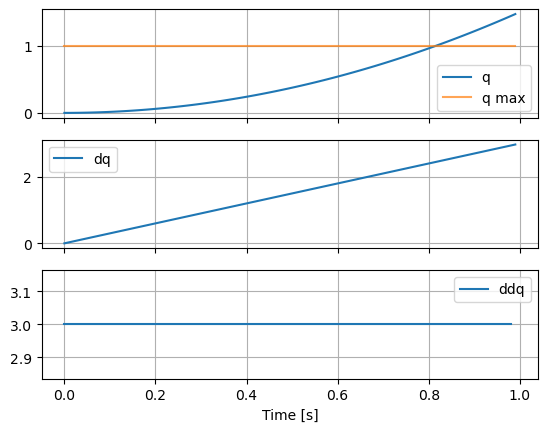

In [25]:
plot_traj()

The joint ended up violating its position bounds!

# How to avoid violating the joint position bounds?

A simple way to ensure that joint bounds are satisfied is to check if the next joint position satisfies them:
$$
q^{pred} = q[i] + \Delta t \, \dot{q}[i] + \frac{\Delta t^2}{2} \, \ddot{q}[i] \le q^{max}
$$

In case this condition is not satisfied, the controller could start decelerating the joint with maximum deceleration:
$$
\ddot{q}[i] = -\ddot{q}^{max}
$$

# Implementation
Let us simulate this to see whether this approach is capable of avoiding the violation of the joint position limits.

In [34]:
q = np.zeros(N)
dq = np.zeros(N)
ddq = np.ones(N-1) * ddq_max

for i in range(N-1):
    q_pred = q[i] + dt*dq[i] + 0.5*dt*dt*ddq[i]
    if(q_pred > q_max):
        ddq[i] = -ddq_max
    q[i+1] = q[i] + dt*dq[i] + 0.5*dt*dt*ddq[i]
    dq[i+1] = dq[i] + dt*ddq[i]

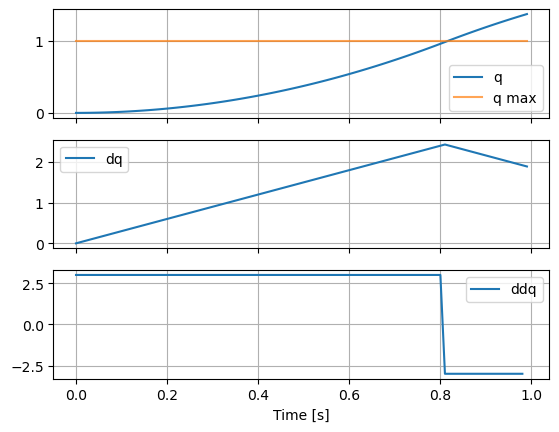

In [35]:
plot_traj()

Even in this case the joint position violated the position bound because the joint started to decelerate when it was already too late!

## Alternative strategy
Using a larger value of $\Delta t$ for the future joint position prediction could mitigate this problem, but it is a heuristic.

Let us give it a try using a time step that is 10 times larger.

In [36]:
dt_pred = 10*dt  # time step used for prediction
q = np.zeros(N)
dq = np.zeros(N)
ddq = np.ones(N-1) * ddq_max

for i in range(N-1):
    q_pred = q[i] + dt_pred*dq[i] + 0.5*dt_pred*dt_pred*ddq[i]
    if(q_pred > q_max):
        ddq[i] = -ddq_max
    q[i+1] = q[i] + dt*dq[i] + 0.5*dt*dt*ddq[i]
    dq[i+1] = dq[i] + dt*ddq[i]

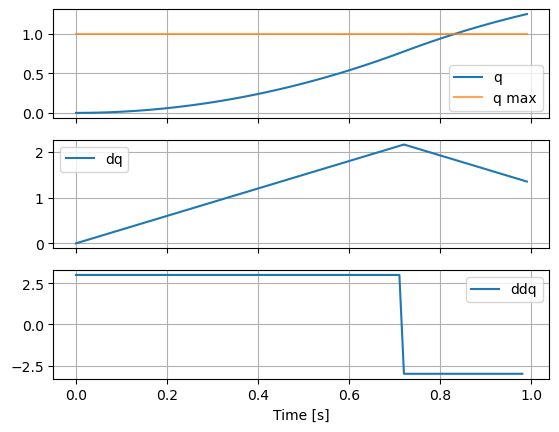

In [37]:
plot_traj()

This time the joint has started decelerating earlier, but it was still unsufficient to prevent violating the joint position limit. 

## Using an even larger time step
What if we set the time step to be 30 times bigger?

In [38]:
dt_pred = 30*dt  # time step used for prediction
q = np.zeros(N)
dq = np.zeros(N)
ddq = np.ones(N-1) * ddq_max

for i in range(N-1):
    q_pred = q[i] + dt_pred*dq[i] + 0.5*dt_pred*dt_pred*ddq[i]
    if(q_pred > q_max):
        ddq[i] = -ddq_max
    q[i+1] = q[i] + dt*dq[i] + 0.5*dt*dt*ddq[i]
    dq[i+1] = dq[i] + dt*ddq[i]

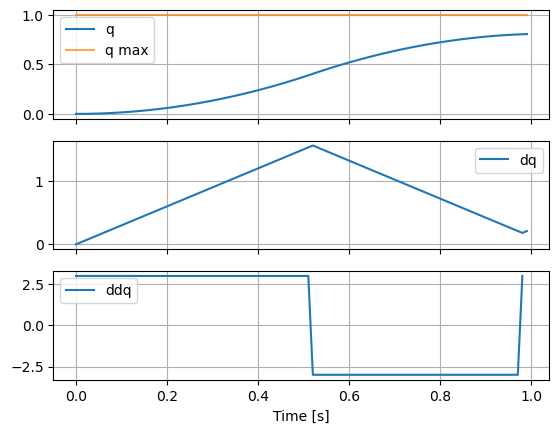

In [39]:
plot_traj()

This time the deceleration has started sufficiently early to prevent the joint position violation. 

However, this has required a hand tuning that is specific to these values of position and acceleration limits.